In [ ]:
### Normalizing Flow

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib notebook

In [36]:
### Functions

class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!',end="")
        fig,ax1 = plt.subplots(1,1)
        
        ax1.set_title('loss vs. epoch')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(self._epoch,self._loss)

def pregauss(chain,data):
    covmat = chain.cov().astype(np.float32)
    mean = chain.getMeans().astype(np.float32)
    
    # bijector time!
    # TriL means the cov matrix is lower triangular. Inverse is easy to compute that way
    # the cholesky factorization takes a positive definite hermitian matrix M (like the covmat) to LL^T with L lower triangluar
    gauss_approx = tfd.MultivariateNormalTriL(loc=mean,scale_tril=tf.linalg.cholesky(covmat))
    bijector = gauss_approx.bijector

    # now map the data
    new_data = bijector.inverse(data.astype(np.float32))
    return new_data,bijector

def train(base,data,bijectors,batch_size,n_epochs):
    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    xdata = np.stack(_data, axis=-1)

    x_data,bij = pregauss(data,xdata)

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 
    
    print('---   Model compiled   ---')
    print(" - N samples = {}".format(nsamples))
    if weights.all()==weights[0]:
        print(" - Uniform weights = {}".format(weights[0]))
    else:
        print(" - Non-uniform weights")
    print(" - Pre-Gaussian Map = True\n")
    print(" - Validation split = {}".format(val_split))
    print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
    print(' - Trainable parameters = {} \n'.format(model.count_params()))
    
    # now perform the fit
    model.fit(x=x_data,
              y=np.zeros((nsamples, dim),dtype=np.float32),
              batch_size=batch_size,
              epochs=n_epochs,
              steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
              validation_split=val_split,
              shuffle=True,
              verbose=False,
              callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    
    return(target_distribution,bij)

def train_nogauss(base,data,bijectors,batch_size,n_epochs):
    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    xdata = np.stack(_data, axis=-1)

    bij = 0

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  loss=lambda _, log_prob: -log_prob) 
    
    print('---   Model compiled   ---')
    print(" - N samples = {}".format(nsamples))
    if weights.all()==weights[0]:
        print(" - Uniform weights = {}".format(weights[0]))
    else:
        print(" - Non-uniform weights")
    print(" - Pre-Gaussian Map = True\n")
    print(" - Validation split = {}".format(val_split))
    print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
    print(' - Trainable parameters = {} \n'.format(model.count_params()))
    
    # now perform the fit
    model.fit(x=xdata,
              y=np.zeros((nsamples, dim),dtype=np.float32),
              batch_size=batch_size,
              epochs=n_epochs,
              steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
              validation_split=val_split,
              shuffle=True,
              verbose=False,
              callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    
    return(target_distribution,bij)

def setup(n_maf,n_params,permute):
    # Set up bijector MADE
    hidden_units=[n_params*2]*2
    print('---   MADE Info   ---')
    print(' - Hidden_units = {}'.format(hidden_units))
    print(' - Activation = {}\n'.format(tf.math.asinh))
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(n_params) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, event_shape=(n_params,), hidden_units=hidden_units, activation=tf.math.asinh, kernel_initializer='glorot_uniform')))
        
    return bijectors

def diff_boost(n_boost,chains,indexes):
    # get data
    chain1 = chains[0].samples
    chain2 = chains[1].samples
    w_chain1 = chains[0].weights
    w_chain2 = chains[1].weights
    ll_chain1 = chains[0].loglikes
    ll_chain2 = chains[1].loglikes

    idx1 = indexes[0]
    idx2 = indexes[1]

    assert len(idx1)==len(idx2)

    # ensure first chain is longer than the second.
    # Need to keep track if I flipped the data so I get the signs right (although in principle it doesn't matter, Its better for everyones results to look the same even if they import chains in different orders)
    flip=False
    if( len(chain1) < len(chain2) ):
        chain1,chain2 = chain2,chain1
        w_chain1,w_chain2 = w_chain2,w_chain1
        ll_chain1,ll_chain2 = ll_chain2,ll_chain1
        idx1,idx2 = idx2,idx1
        flip=True
    
    N1 = len(chain1)
    N2 = len(chain2)
    #print('N1 = {}'.format(N1))
    #print('N2 = {}'.format(N2))

    # set up parameter diff arrays
    diff = np.zeros((N1*n_boost,len(idx1)),dtype=np.float32)
    weights = np.zeros(N1*n_boost,dtype=np.float32)
    loglikes = np.zeros(N1*n_boost,dtype=np.float32)
        
    for i in range(n_boost):
        # find the range of indices to use for chain 2
        lower = int((i/n_boost)*N1)
        upper = lower+N1

        # compute stuff
        if flip==True:
            diff[i*N1:(i+1)*N1] = -chain1[:N1,idx1] + np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
        else:
            diff[i*N1:(i+1)*N1] = chain1[:N1,idx1] - np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')

        weights[i*N1:(i+1)*N1] = w_chain1*np.take(w_chain2, range(lower,upper), mode='wrap')
        loglikes[i*N1:(i+1)*N1] = ll_chain1+np.take(ll_chain2, range(lower,upper), mode='wrap')

    min_weight_ratio = min(chains[0].min_weight_ratio,
                               chains[1].min_weight_ratio)

    diff_samples = WeightedSamples(ignore_rows=0,
                                   samples=diff,
                                   weights=weights, loglikes=loglikes,
                                   name_tag=' ', label=' ',
                                   min_weight_ratio=min_weight_ratio)

    return diff_samples

def permute_chains(chain1,chain2):
    #get indiv chains
    #_chains_1 = chain1.getSeparateChains()
    #_chains_2 = chain2.getSeparateChains()
    param_names_1 = chain1.getParamNames().getRunningNames()
    param_names_2 = chain2.getParamNames().getRunningNames()

    # find only the params in both chains
    common_params = [param for param in param_names_1 if param in param_names_2]

    idx_1 = [param_names_1.index(param) for param in param_names_1 if param in param_names_2]
    idx_2 = [param_names_2.index(param) for param in param_names_2 if param in param_names_1]

    chains=[]

    for ch1 in _chains_1:
        for ch2 in _chains_2:
            chains.append([ch1,ch2])
    
    return chains,[idx_2,idx_2],common_params

def significance(trained_dist,nparams):
    prob = trained_dist.prob(bijector.inverse(np.zeros(nparams,dtype=np.float32)))

    n_points = 10000
    n_pass = 0

    _s = trained_dist.sample(n_points)
    _v = trained_dist.prob(_s)
    for val in _v:
        if val>prob:
            n_pass+=1

    n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
    return n_sigma,n_pass/n_points

def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    #plt.show()

/home/grads/data/evan/tension_calibration/mc_data/fiducial.txt
Removed no burn in
/home/grads/data/evan/tension_calibration/mc_data/noise_0.6827.txt
Removed no burn in
/home/grads/data/evan/tension_calibration/mc_data/noise_0.9545.txt
Removed no burn in
/home/grads/data/evan/tension_calibration/mc_data/noise_0.9973.txt
Removed no burn in
/home/grads/data/evan/tension_calibration/mc_data/noise_1.txt
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


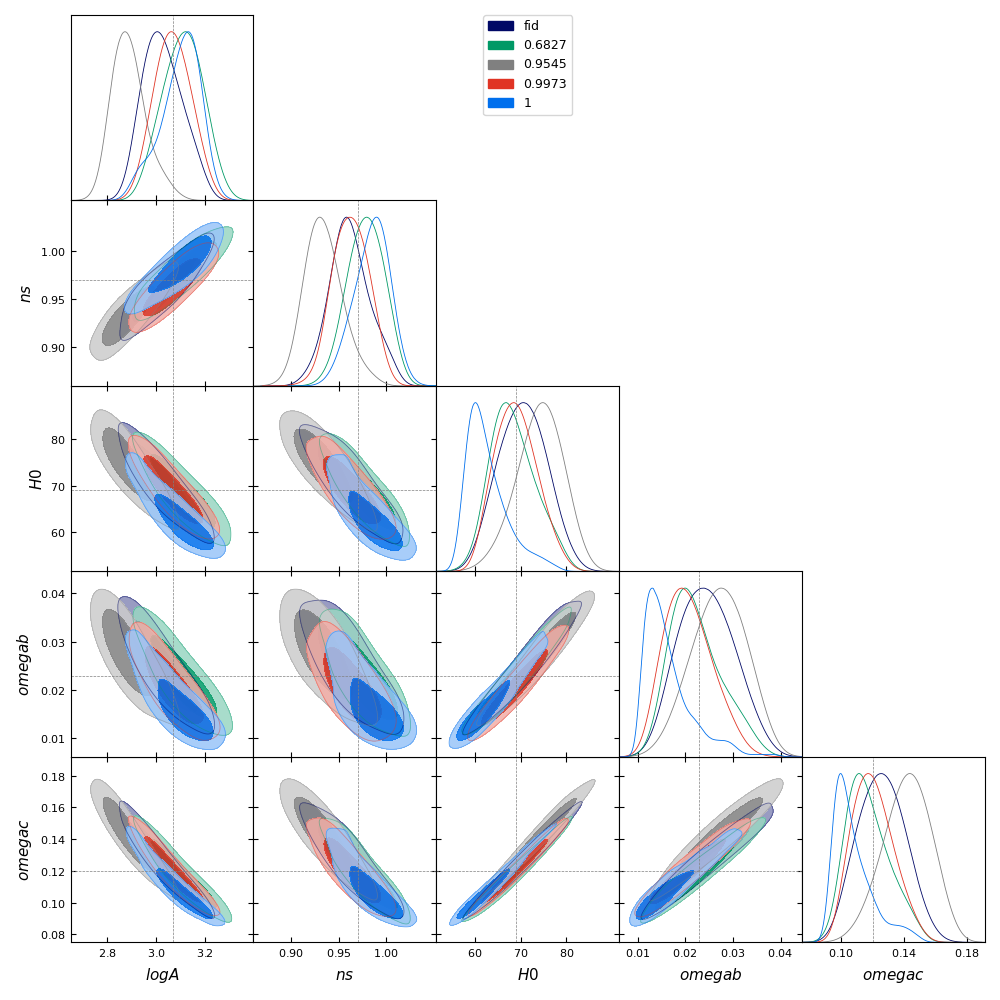

In [40]:
## Import chains
d = '/home/grads/data/evan/tension_calibration/mc_data/'
cl = [0.6827,0.9545,0.9973,1]

chain_1 = getdist.mcsamples.loadMCSamples(file_root=d+'fiducial', no_cache=True)
chain_2 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[0]), no_cache=True)
chain_3 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[1]), no_cache=True)
chain_4 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[2]), no_cache=True)
chain_5 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[3]), no_cache=True)

#plt.ion()
#
plot_cosmo_contours([chain_1.samples,chain_2.samples,chain_3.samples,chain_4.samples,chain_5.samples],['fid',str(cl[0]),str(cl[1]),str(cl[2]),str(cl[3])])
#plt.ion()
#plt.show()
#Note that the close chisquared is to ~1500 the more overlap there should be.

Removed no burn in


<IPython.core.display.Javascript object>


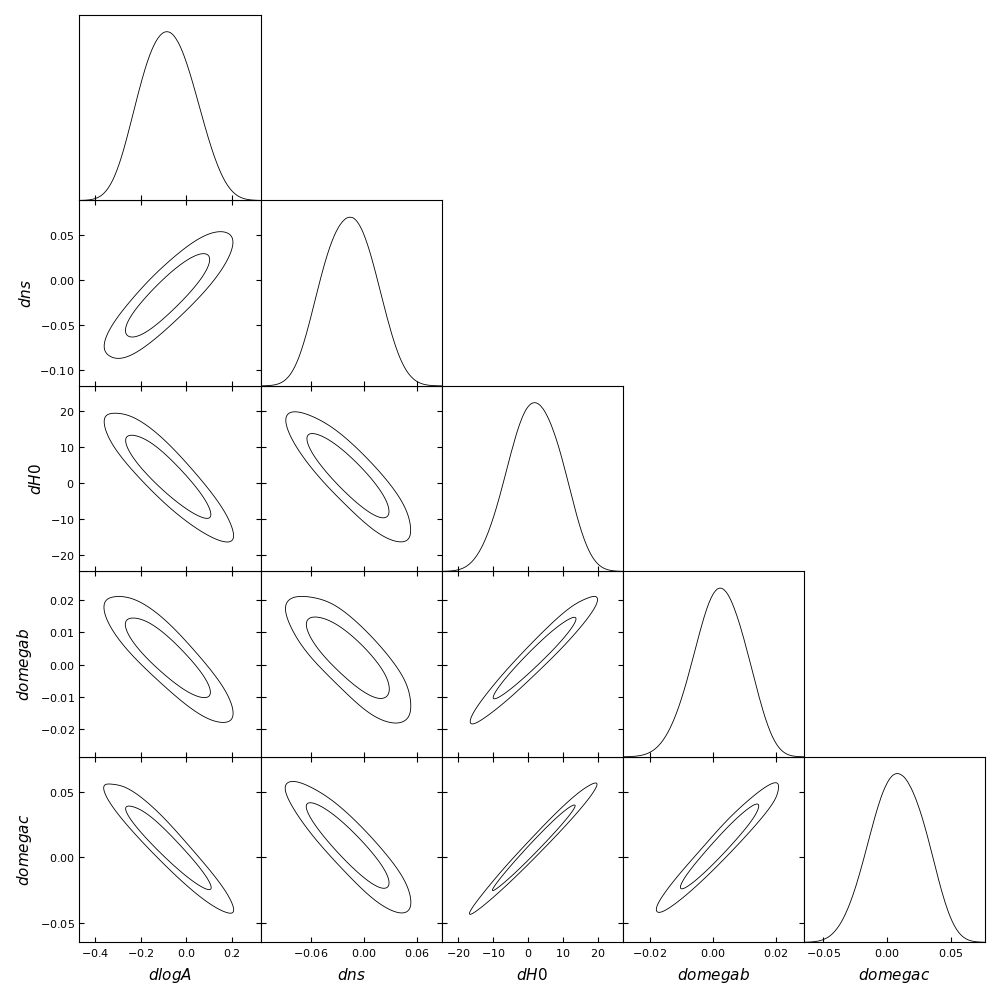

---   MADE Info   ---
 - Hidden_units = [10, 10]
 - Activation = <function asinh at 0x7f39594f1dd0>

---   Model compiled   ---
 - N samples = 48000
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 10 
 - Trainable parameters = 2800 

[####################] Completed!. (epoch 99/100)

<IPython.core.display.Javascript object>


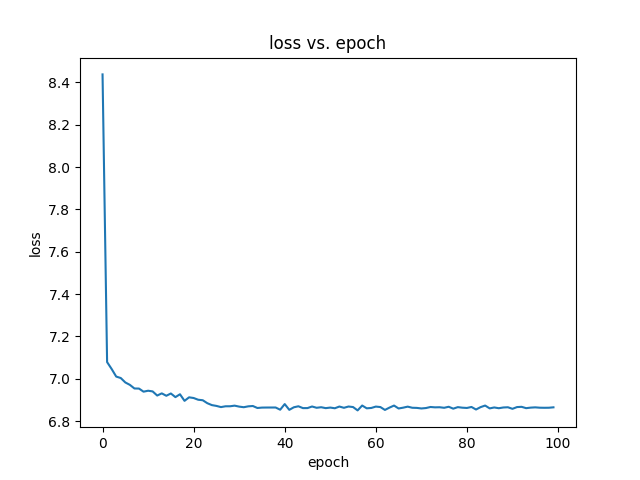

In [41]:
# Now the NF

# find only the params in both chains
param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()

common_params = [param for param in param_names_1 if param in param_names_2]

names = []

for param in common_params:
    names.append('d'+param)
    
# arrange arrays so chain1 is longer
if( len(chain_1.samples)>len(chain_2.samples) ):
    chain_1,chain_2 = chain_2,chain_1
    
    len_diff = len(chain_1.samples)-len(chain_2.samples)
    print(len_diff)
    
    p_diff = chain_1.samples[0:len(chain_2)] - chain_2.samples
else:
    p_diff = -1*(chain_2.samples[0:len(chain_1.samples)] - chain_1.samples)



param_diff_chain = MCSamples(samples=p_diff,names=names,labels=names)

g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot(param_diff_chain,
                params=names,
                filled=False)

n_params = len(param_diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=1000,n_epochs=100)

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


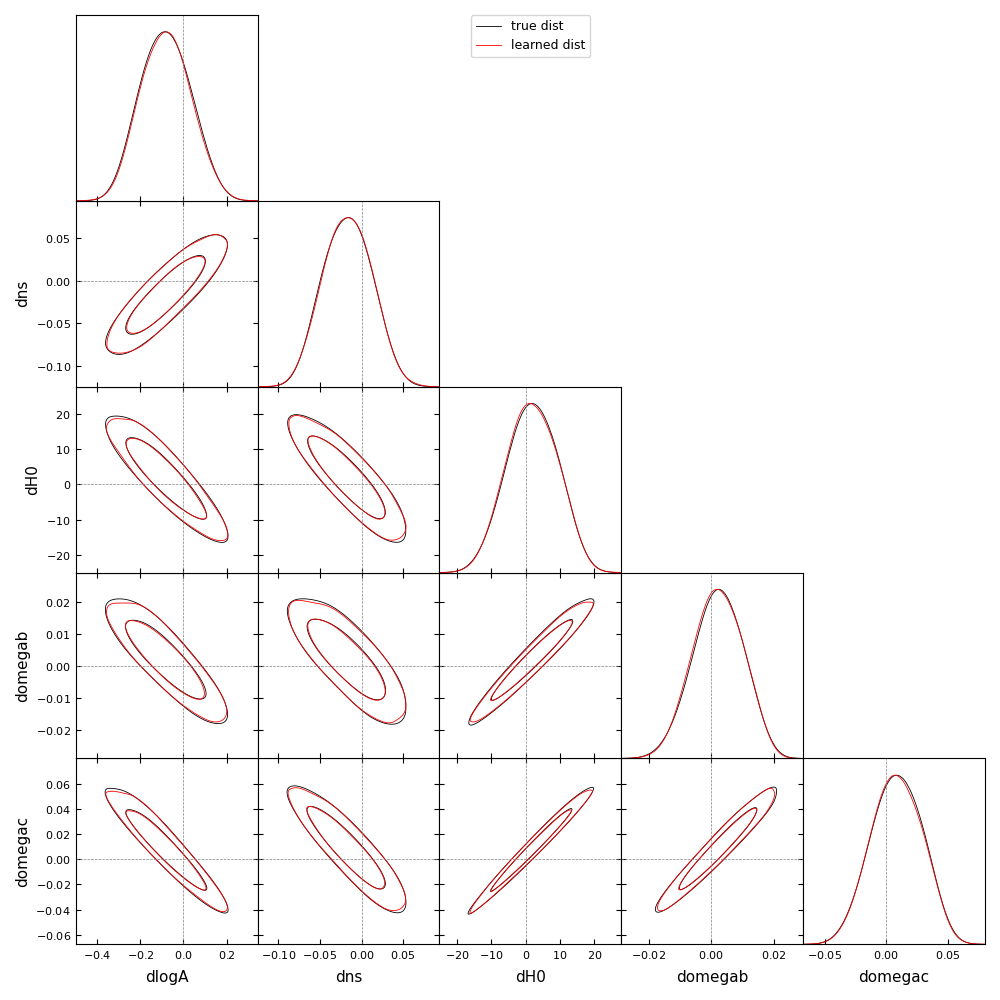

In [42]:
# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=names,label='learned dist')
param_diff_chain = MCSamples(samples=p_diff,names=names,label='true dist')
g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_diff_chain,sample],
                params=names,
                filled=False,
                markers={_p:0 for _p in names})

plt.ion()
plt.show()

In [43]:
nsigma,P = significance(trained_dist,n_params)
print('nsigma = {}'.format(nsigma))
print('P shift = {}'.format(P))

nsigma = 0.06484174960028356
P shift = 0.0517


Removed no burn in


<IPython.core.display.Javascript object>


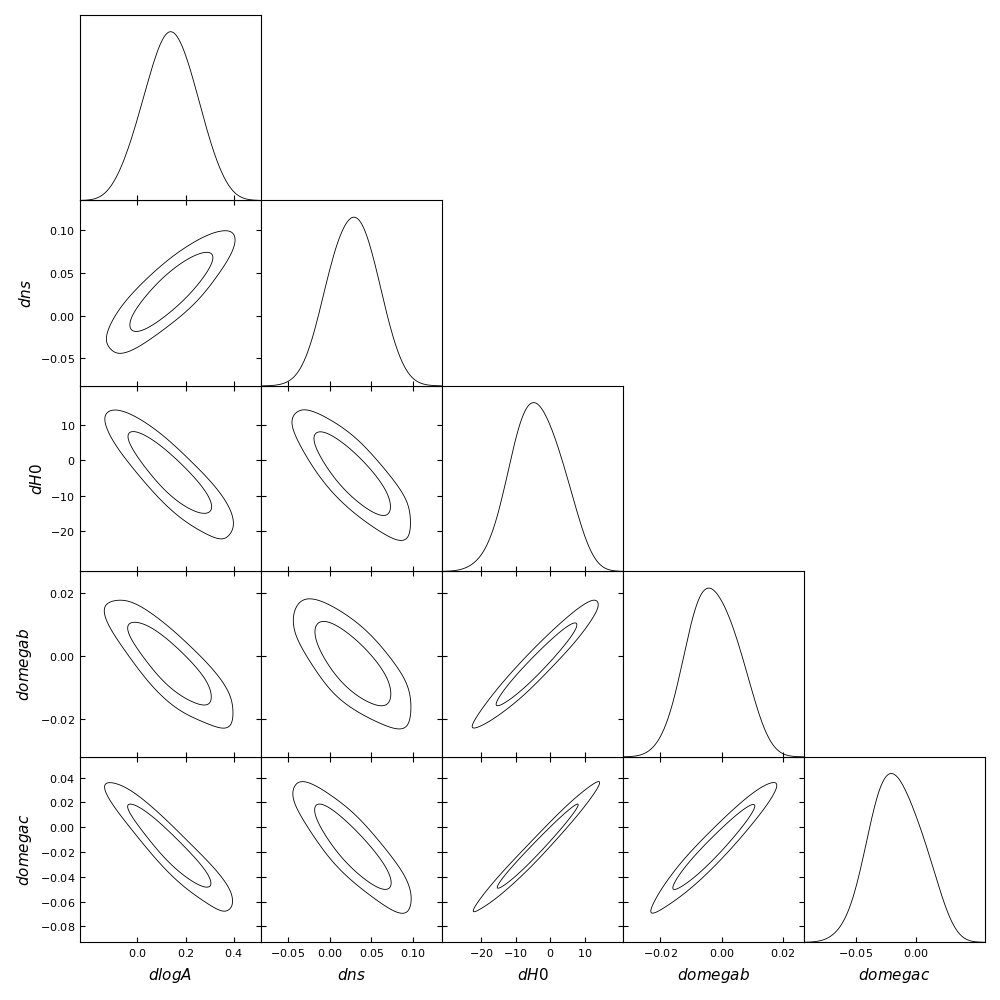

---   MADE Info   ---
 - Hidden_units = [10, 10]
 - Activation = <function asinh at 0x7f39594f1dd0>

---   Model compiled   ---
 - N samples = 48000
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 10 
 - Trainable parameters = 2800 

[####################] Completed!. (epoch 99/100)

<IPython.core.display.Javascript object>


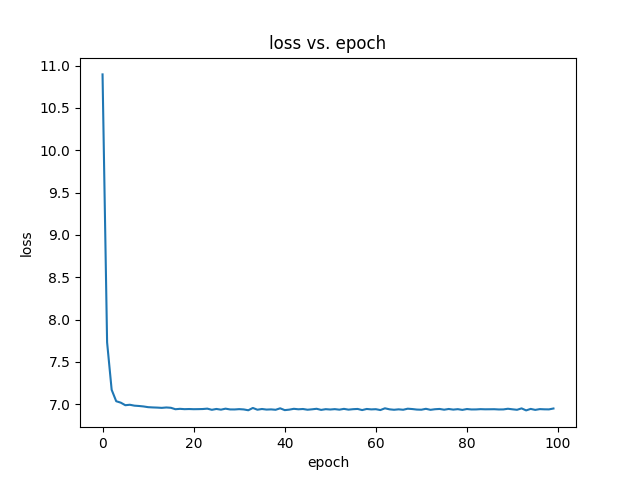

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


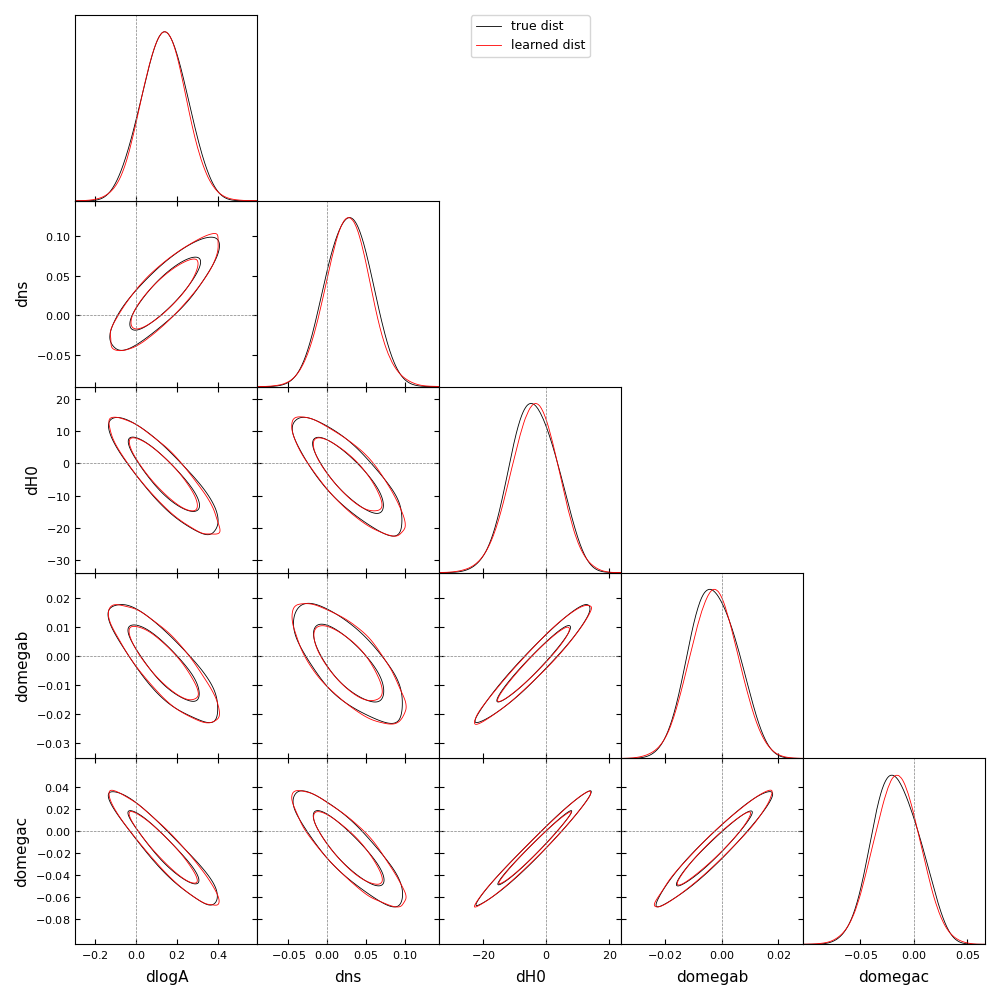

nsigma = 0.35005156428179435
P shift = 0.2737


In [44]:
# Now the NF
chain_2 = chain_3

# find only the params in both chains
param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()

common_params = [param for param in param_names_1 if param in param_names_2]

names = []

for param in common_params:
    names.append('d'+param)
    
# arrange arrays so chain1 is longer
if( len(chain_1.samples)>len(chain_2.samples) ):
    chain_1,chain_2 = chain_2,chain_1
    
    len_diff = len(chain_1.samples)-len(chain_2.samples)
    print(len_diff)
    
    p_diff = chain_1.samples[0:len(chain_2)] - chain_2.samples
else:
    p_diff = -1*(chain_2.samples[0:len(chain_1.samples)] - chain_1.samples)



param_diff_chain = MCSamples(samples=p_diff,names=names,labels=names)

g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot(param_diff_chain,
                params=names,
                filled=False)

n_params = len(param_diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=1000,n_epochs=100)

# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=names,label='learned dist')
param_diff_chain = MCSamples(samples=p_diff,names=names,label='true dist')
g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_diff_chain,sample],
                params=names,
                filled=False,
                markers={_p:0 for _p in names})

plt.ion()
plt.show()
nsigma,P = significance(trained_dist,n_params)

print('nsigma = {}'.format(nsigma))
print('P shift = {}'.format(P))

Removed no burn in


<IPython.core.display.Javascript object>


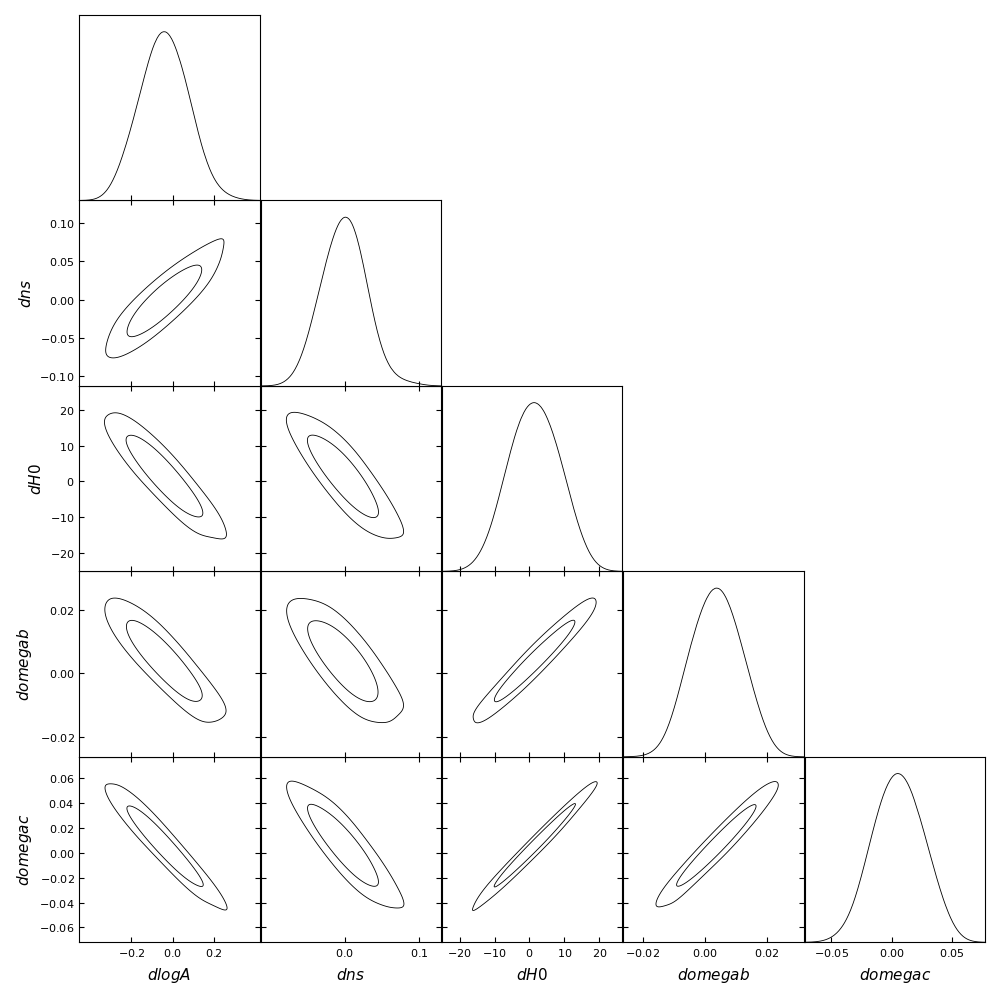

---   MADE Info   ---
 - Hidden_units = [10, 10]
 - Activation = <function asinh at 0x7f39594f1dd0>

---   Model compiled   ---
 - N samples = 48000
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 10 
 - Trainable parameters = 2800 

[####################] Completed!. (epoch 99/100)

<IPython.core.display.Javascript object>


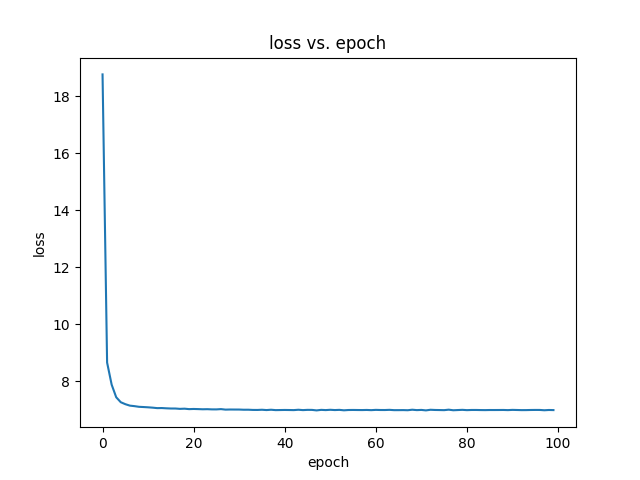

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


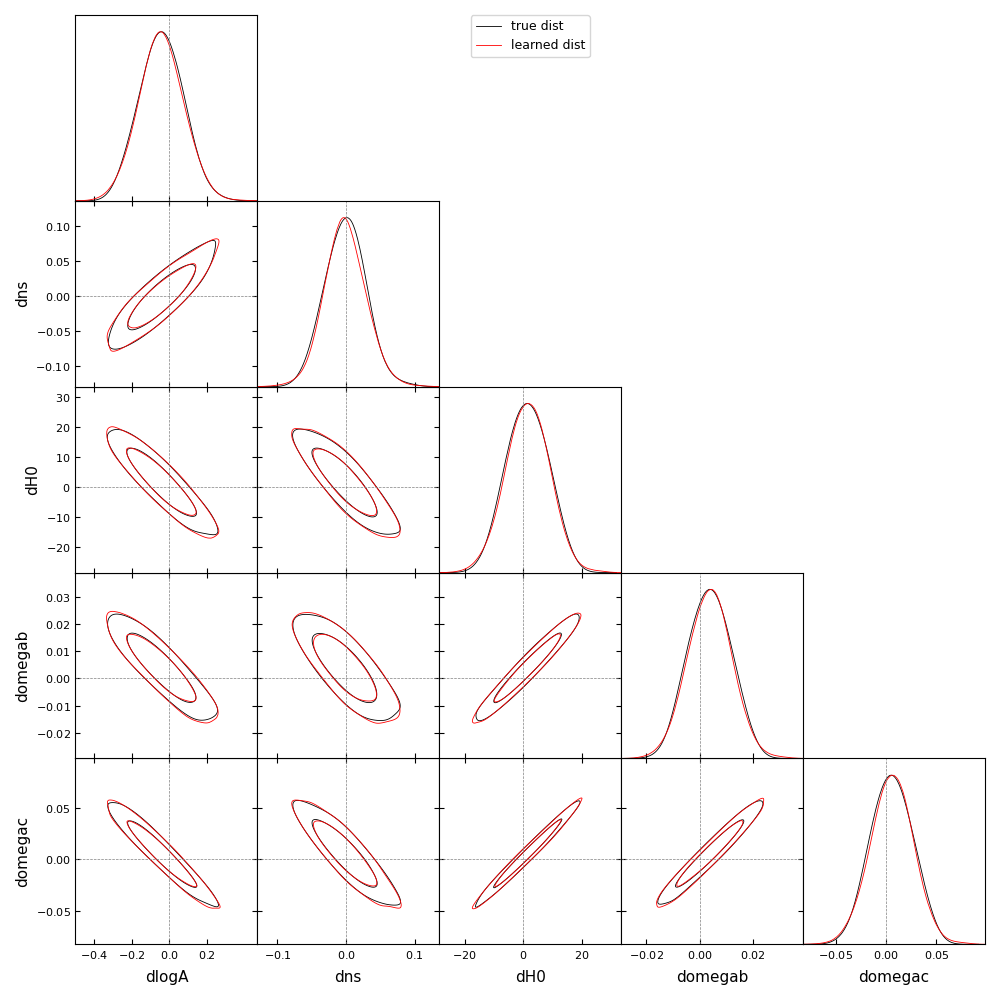

nsigma = 0.18439957908313243
P shift = 0.1463


In [45]:
# Now the NF
chain_2 = chain_4

# find only the params in both chains
param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()

common_params = [param for param in param_names_1 if param in param_names_2]

names = []

for param in common_params:
    names.append('d'+param)
    
# arrange arrays so chain1 is longer
if( len(chain_1.samples)>len(chain_2.samples) ):
    chain_1,chain_2 = chain_2,chain_1
    
    len_diff = len(chain_1.samples)-len(chain_2.samples)
    print(len_diff)
    
    p_diff = chain_1.samples[0:len(chain_2)] - chain_2.samples
else:
    p_diff = -1*(chain_2.samples[0:len(chain_1.samples)] - chain_1.samples)



param_diff_chain = MCSamples(samples=p_diff,names=names,labels=names)

g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot(param_diff_chain,
                params=names,
                filled=False)

n_params = len(param_diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=1000,n_epochs=100)

# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=names,label='learned dist')
param_diff_chain = MCSamples(samples=p_diff,names=names,label='true dist')
g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_diff_chain,sample],
                params=names,
                filled=False,
                markers={_p:0 for _p in names})

plt.ion()
plt.show()
nsigma,P = significance(trained_dist,n_params)

print('nsigma = {}'.format(nsigma))
print('P shift = {}'.format(P))

Removed no burn in


<IPython.core.display.Javascript object>


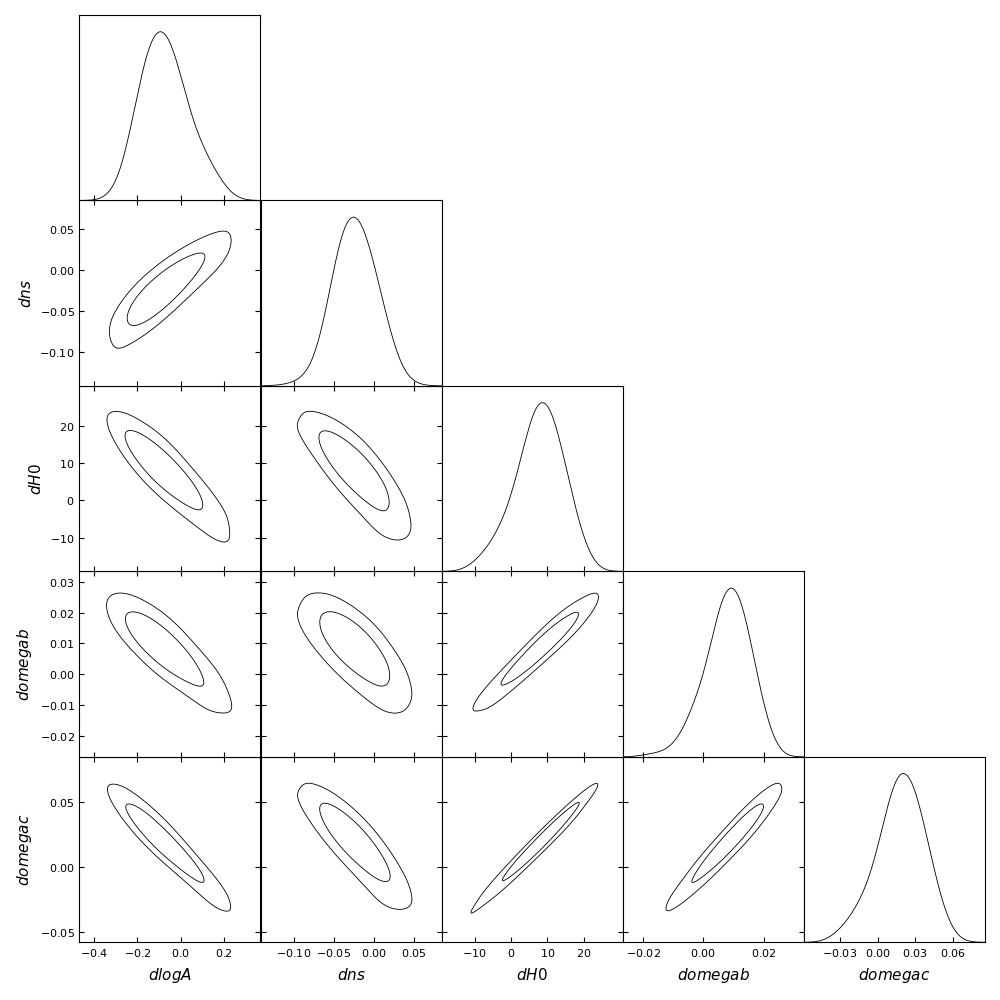

---   MADE Info   ---
 - Hidden_units = [10, 10]
 - Activation = <function asinh at 0x7f39594f1dd0>

---   Model compiled   ---
 - N samples = 48000
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 10 
 - Trainable parameters = 2800 

[####################] Completed!. (epoch 99/100)

<IPython.core.display.Javascript object>


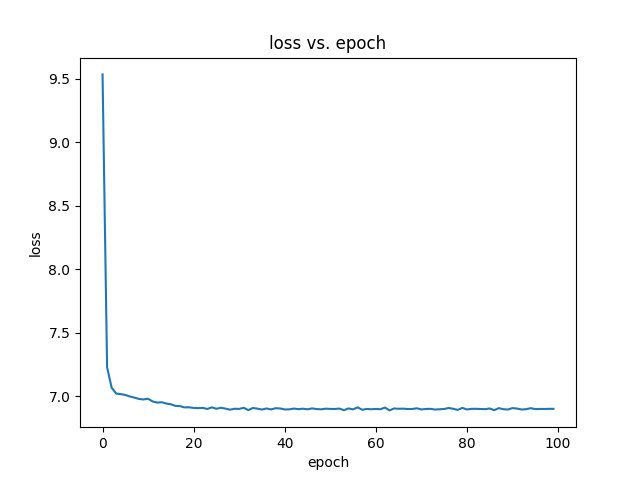

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


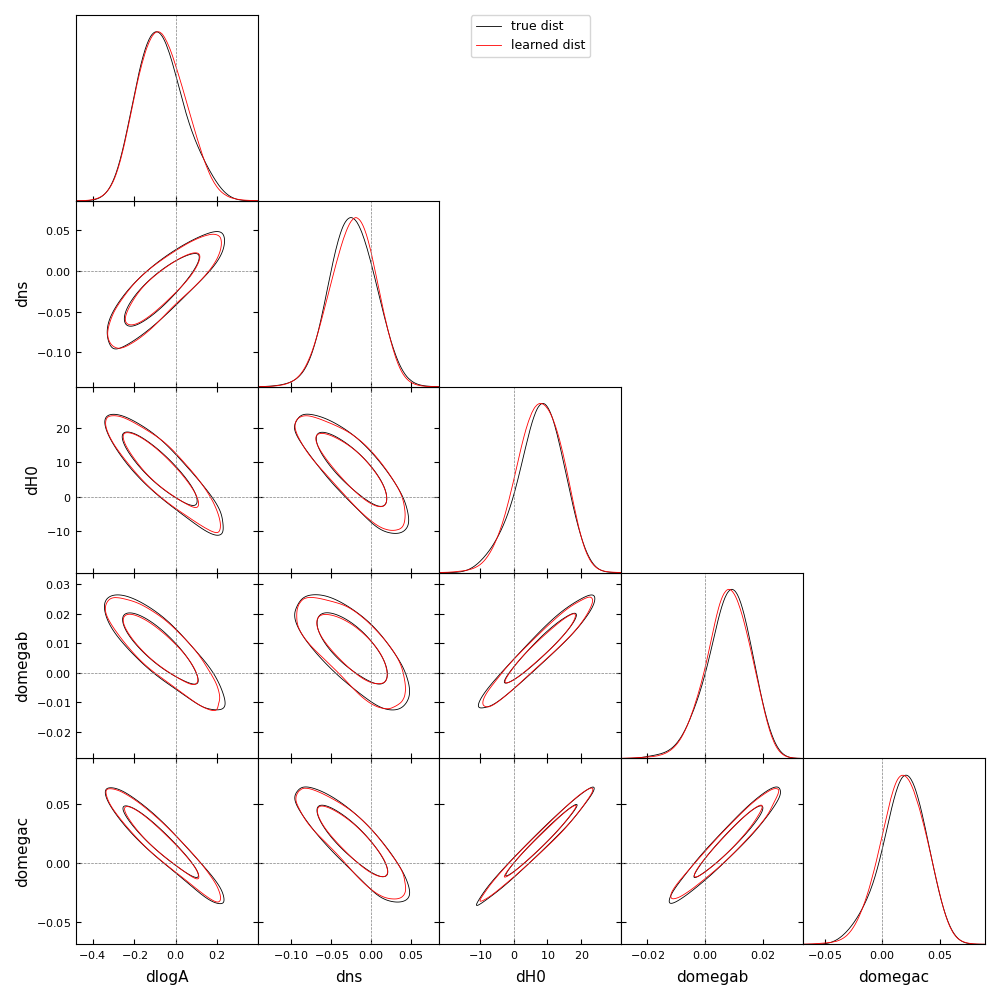

nsigma = 0.17242934969848564
P shift = 0.1369


In [46]:
# Now the NF
chain_2 = chain_5

# find only the params in both chains
param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()

common_params = [param for param in param_names_1 if param in param_names_2]

names = []

for param in common_params:
    names.append('d'+param)
    
# arrange arrays so chain1 is longer
if( len(chain_1.samples)>len(chain_2.samples) ):
    chain_1,chain_2 = chain_2,chain_1
    
    len_diff = len(chain_1.samples)-len(chain_2.samples)
    print(len_diff)
    
    p_diff = chain_1.samples[0:len(chain_2)] - chain_2.samples
else:
    p_diff = -1*(chain_2.samples[0:len(chain_1.samples)] - chain_1.samples)



param_diff_chain = MCSamples(samples=p_diff,names=names,labels=names)

g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot(param_diff_chain,
                params=names,
                filled=False)

n_params = len(param_diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=1000,n_epochs=100)

# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=names,label='learned dist')
param_diff_chain = MCSamples(samples=p_diff,names=names,label='true dist')
g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_diff_chain,sample],
                params=names,
                filled=False,
                markers={_p:0 for _p in names})

plt.ion()
plt.show()
nsigma,P = significance(trained_dist,n_params)

print('nsigma = {}'.format(nsigma))
print('P shift = {}'.format(P))